# openFE Atom Mappers

## Build test data:
Initially start with some example data

In [1]:
import openfe
from openff.toolkit.topology import Molecule

# First, create some molecules to work with
benzene = Molecule.from_smiles('c1ccccc1')
benzene.name = 'benzene'
toluene = Molecule.from_smiles('c1ccccc1C')
toluene.name = "toluene"
phenol = Molecule.from_smiles('c1ccccc1O')
phenol.name = 'phenol'
catechol = Molecule.from_smiles('c1cccc(O)c1O')
catechol.name = 'catechol'
nitrobenzene = Molecule.from_smiles('C1=CC=C(C=C1)[N+](=O)[O-]')
nitrobenzene.name = 'nitrobenzene'
cyclohexane = Molecule.from_smiles('C1CCCCC1')
cyclohexane.name = 'cyclohexane'

mols = [benzene, toluene, phenol, catechol, nitrobenzene, cyclohexane]
[x.generate_conformers() for x in mols]
mols = list(map(lambda x: openfe.setup.SmallMoleculeComponent.from_openff(x, x.name), mols))

molA = mols[1]
molB = mols[3]

molA, molB

/home/riesbenj/Programs/miniconda3/envs/openfe/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/riesbenj/Programs/miniconda3/envs/openfe/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/riesbenj/Programs/miniconda3/envs/openfe/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/riesbenj/Programs/miniconda3/envs/openfe/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


(SmallMoleculeComponent(name=toluene), SmallMoleculeComponent(name=catechol))

# Atom Mappers
## Lomap Mapper

In [2]:
# LomapAtomMapper wraps the lomap.mcs.MCS object
lomap_mapper = openfe.setup.LomapAtomMapper()

        
# mappers can return an *iterable* of mappings,
# for our case just grab the first with `next()`
lomap_mapping = next(lomap_mapper.suggest_mappings(molA, molB))

#perses_scorer = openfe.setup.atom_mapping.perses_scorers.default_perses_scorer
lomap_scorer = openfe.setup.lomap_scorers.default_lomap_score
print(f"Lomap-Score is {lomap_scorer(lomap_mapping)}")
#print(f"Perses-Score is {perses_scorer(lomap_mapping)}")

lomap_mapping

TypeError: __init__() got an unexpected keyword argument 'element_change'

In [ ]:
#Let s align a ton of molecueles :) 
# LomapAtomMapper wraps the lomap.mcs.MCS object
lomap_mapper = openfe.setup.LomapAtomMapper()

for molA in mols:
    for molB in mols:        
        if molA == molB:
            continue
        # mappers can return an *iterable* of mappings,
        # for our case just grab the first with `next()`
        lomap_mapping = next(lomap_mapper.suggest_mappings(molA, molB))

        #perses_scorer = openfe.setup.atom_mapping.perses_scorers.default_perses_scorer
        lomap_scorer = openfe.setup.lomap_scorers.default_lomap_score
        print(f"Lomap-Score is {lomap_scorer(lomap_mapping)}")
        #print(f"Perses-Score is {perses_scorer(lomap_mapping)}")

        display(lomap_mapping)

In [ ]:
vars(lomap_mapping)(just a cursory review for now)(just a cursory review for now)

## Perses Mapper

In [ ]:
# LomapAtomMapper wraps the lomap.mcs.MCS object
perses_mapper = openfe.setup.atom_mapping.PersesAtomMapper()
#perses_scorer = openfe.setup.PersesScorer

# mappers can return an *iterable* of mappings,
# for our case just grab the first with `next()`
perses_mapping = next(perses_mapper.suggest_mappings(molA, molB))

perses_scorer = openfe.setup.atom_mapping.perses_scorers.default_perses_scorer
lomap_scorer = openfe.setup.atom_mapping.lomap_scorers.default_lomap_score
print(f"Lomap-Score is {lomap_scorer(perses_mapping)}")
print(f"Perses-Score is {perses_scorer(perses_mapping)}")

perses_mapping

## The Rdkit - Gowers Variant

Lomap-Score is 0.1392920235749422
Perses-Score is 0.9404761904761905


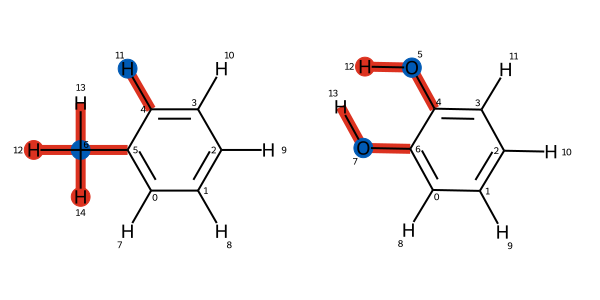

In [5]:
# LomapAtomMapper wraps the lomap.mcs.MCS object
rdfmcs_mapper = openfe.setup.atom_mapping.RDFMCSMapper()

# mappers can return an *iterable* of mappings,
# for our case just grab the first with `next()`
rdfmcs_mapping = next(rdfmcs_mapper.suggest_mappings(molA, molB))

perses_scorer = openfe.setup.atom_mapping.perses_scorers.default_perses_scorer
lomap_scorer = openfe.setup.atom_mapping.lomap_scorers.default_lomap_score
print(f"Lomap-Score is {lomap_scorer(rdfmcs_mapping)}")
print(f"Perses-Score is {perses_scorer(rdfmcs_mapping)}")

rdfmcs_mapping

# Use of Atom Mappers as iterables

In [ ]:
#Get multiple mappings
from IPython.display import display

perses_scorer = openfe.setup.atom_mapping.perses_scorers.default_perses_scorer
lomap_scorer = openfe.setup.atom_mapping.lomap_scorers.default_lomap_score

for x in perses_mapper.suggest_mappings(molA, molB):
    display(x)

    print(f"Lomap-Score is {lomap_scorer(x)}")
    print(f"Perses-Score is {perses_scorer(x, use_positions=True, normalize=False)}")

In [ ]:
def lomap_basic_test_files_dir():
    # for lomap, which wants the files in a directory
    lomap_files = 'lomap_files' # tmpdir_factory.mktemp('lomap_files')
    lomap_basic = 'openfe.tests.data.lomap_basic'

    for f in importlib.resources.contents(lomap_basic):
        if not f.endswith('mol2'):
            continue
        stuff = importlib.resources.read_binary(lomap_basic, f)

        with open(str(lomap_files.join(f)), 'wb') as fout:
            fout.write(stuff)

    yield str(lomap_files)


In [ ]:
lomap_basic_test_files_dirs = lomap_basic_test_files_dir()

In [ ]:
import importlib
import string
import pytest
from importlib import resources
from rdkit import Chem
from openmm.app import PDBFile
from gufe.smallmoleculecomponent import SmallMoleculeComponent

def atom_mapping_basic_test_files():
    # a dict of {filenames.strip(mol2): SmallMoleculeComponent} for a simple
    # set of ligands
    files = {}
    for f in [
        '1,3,7-trimethylnaphthalene',
        '1-butyl-4-methylbenzene',
        '2,6-dimethylnaphthalene',
        '2-methyl-6-propylnaphthalene',
        '2-methylnaphthalene',
        '2-naftanol',
        'methylcyclohexane',
        'toluene']:
        with importlib.resources.path('openfe.tests.data.lomap_basic',
                                      f + '.mol2') as fn:
            mol = Chem.MolFromMol2File(str(fn), removeHs=False)
            files[f] = SmallMoleculeComponent(mol, name=f)

    return files



In [ ]:
mols = atom_mapping_basic_test_files()

In [ ]:
from lomap import mcs as lomap_mcs

dbmols = lomap.DBMolecules('/home/riesbenj/Code/OpenFE/openfe/openfe/tests/data/lomap_basic')
_,_ =dbmols.build_matrices()

In [ ]:
a = {1:2, 2:3}

In [ ]:
dbmols.mcs_map_store


In [ ]:
dbmols.nums()

In [ ]:
import numpy as np

In [ ]:
np.sqrt(28)

In [ ]:
np.max(list(dbmols.mcs_map_store.keys()))

In [ ]:
##